# `hw4`: Heart failure prediction

In [1]:
# Fill in this cell with your personal details:
# - Name: Robert Florea
# - Student ID: S201068
# - Email: robert.florea@student.uliege.be

Deadline: **Friday, December 20, 23:59**.

Instructions:
- Submit your completed notebook on your personal Github repository created when accepting the assignment.
- All cells must be executable and their outputs should not be erased before submission.
- This case study must be carried out alone. You are not allowed to discuss or collaborate with other students.
- In January, you will have to explain and defend your solution during a 30-minute oral exam.
- The take-home exam (including its defense in January) will account for 50% of the final grade.

Comments:
- Solve the case study below by following the Bayesian workflow as best as possible.
- Follow the data visualization principles to make your plots effective and readable.
- Make the best use of the Python scientific ecosystem.
- Feel free to add comments when necessary.

# Introduction

Cardiovascular diseases are the number 1 cause of death globally, taking an estimated 17 million lives each year. In this case study, you will explore a dataset of health records of 299 patients who had heart failure, collected by [Chicco and Jurman](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5) (2020). Each patient profile includes 13 features based on their clinical and physical conditions. Your task is to analyze this dataset to understand which features correlate most strongly with heart failure.


In [2]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import emcee
import networkx as nx
import random
import corner

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx

from scipy.spatial.distance import mahalanobis
from sklearn.covariance import MinCovDet
from scipy.optimize import minimize
from scipy.stats import norm, uniform
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Data exploration

<div class="alert alert-success">
    
**Q1**. Load the `heart.csv` dataset into a data frame.
    
</div>

In [3]:
data = pd.read_csv("heart.csv")

<div class="alert alert-success">
    
**Q2**. Explore the dataset and report relevant insights. 

</div>

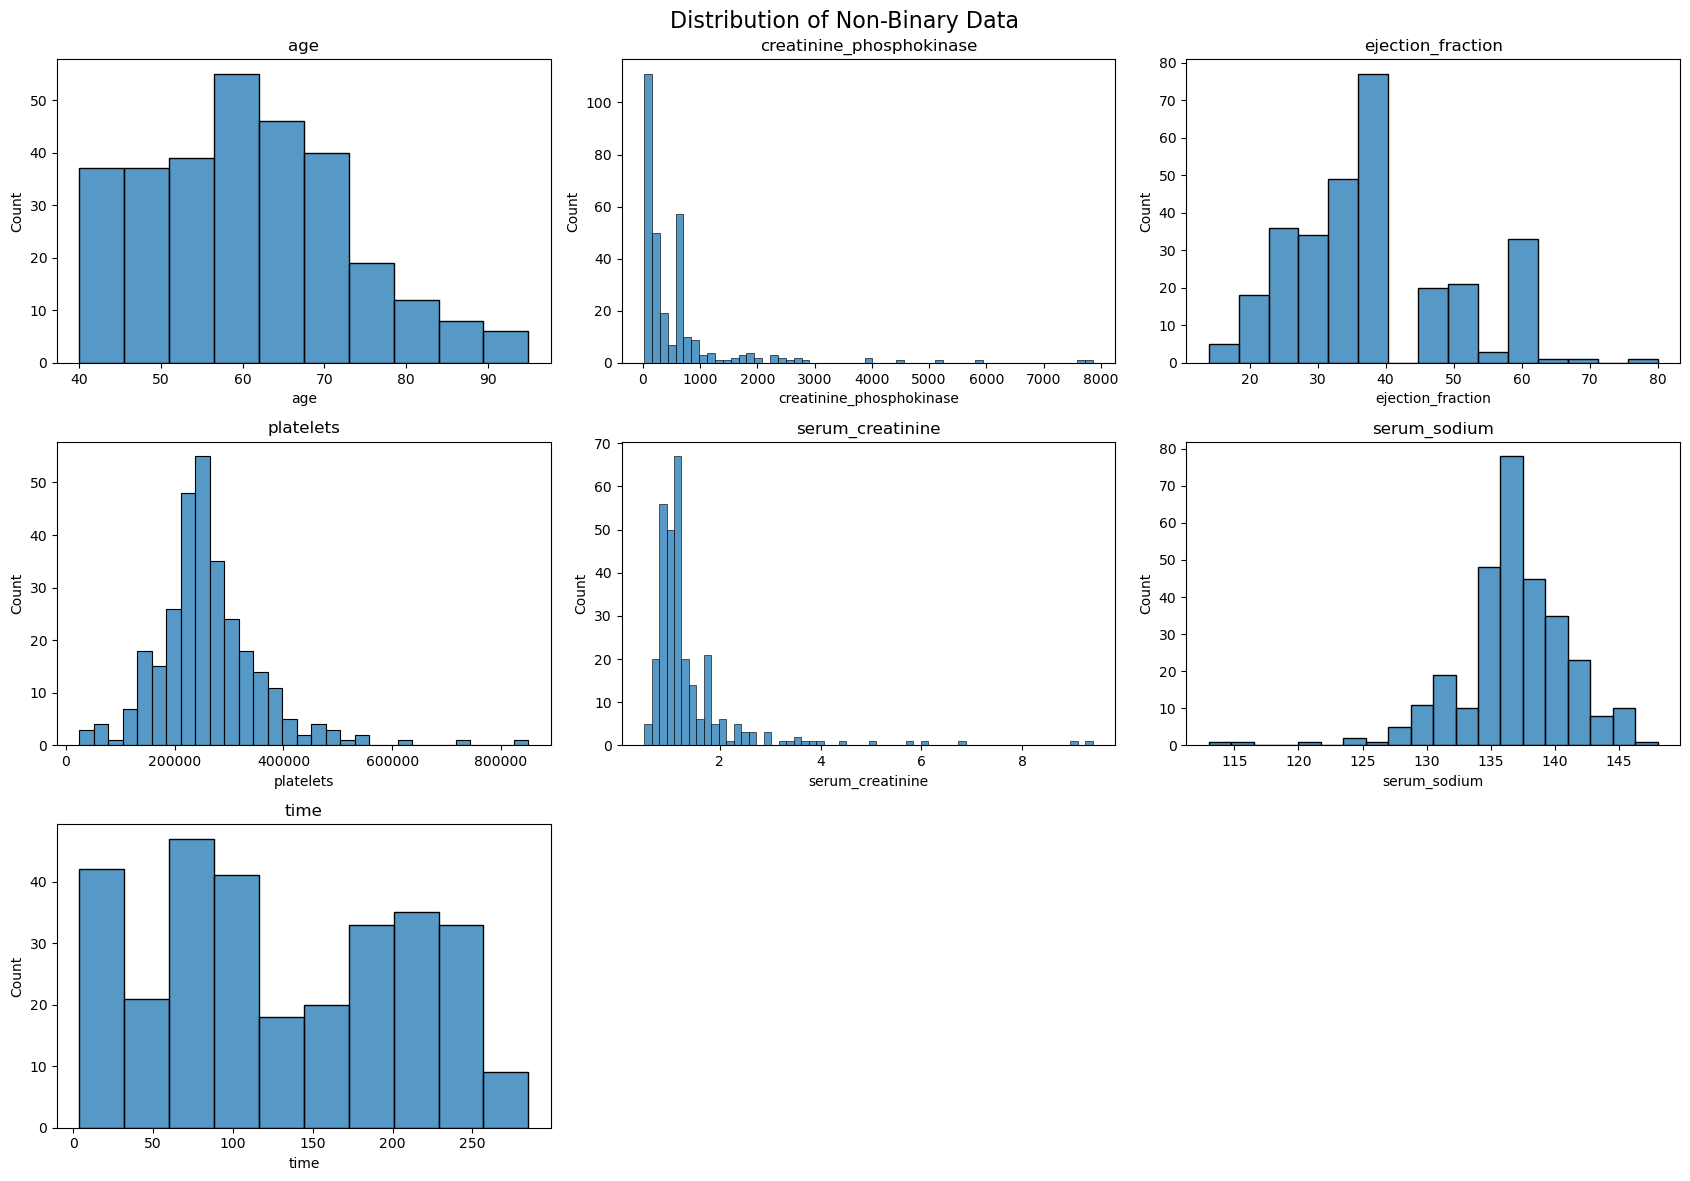

In [4]:
non_binary_data = data[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']].copy()
binary_data = data[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']].copy()

#histograms of the non-binary data
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 12))
axes = axes.flatten()

for ax, col in zip(axes, non_binary_data.columns):
    sns.histplot(non_binary_data[col], ax=ax)
    ax.set_title(col)

# hide the last plots
for ax in axes[len(non_binary_data.columns):]:
    ax.set_visible(False)

fig.suptitle("Distribution of Non-Binary Data", fontsize=16)
plt.tight_layout()
plt.show()

Let's examine the notable distributions of our features:
- platelets : the distribution appears approximately normal with a few outliers on the right. These outliers are not necessarily incorrect measurements; they could reflect patients with specific health conditions.
- serum_sodium : the distribution is close to normal, with a few outliers on the left. Similar to platelets, these values likely reflect certain health issues in patients rather than errors in measurement.
- serum_creatinine & creatinine_phosphokinase : both features show a high concentration of values near their mode, with some points significantly deviating from the central tendency. These outliers likely indicate patients with specific health issues.
- time : the values are roughly uniformly distributed across the range, though there are slight fluctuations with some areas showing higher or lower frequencies. However, these variations are not extreme enough to indicate significant tails.
- age : the distribution is slightly skewed toward younger ages, with most patients falling between 50 and 70 years old. This range reflects the typical demographic for patients at risk of heart failure or cardiovascular events. The smaller number of patients in extreme age ranges suggests a focus on middle-aged and older adults.

Note : features like serum_creatinine and creatinine_phosphokinase are highly skewed, which may benefit from a logarithmic transformations to normalize their distributions before applying a model. We will see later it this is helpful or not.

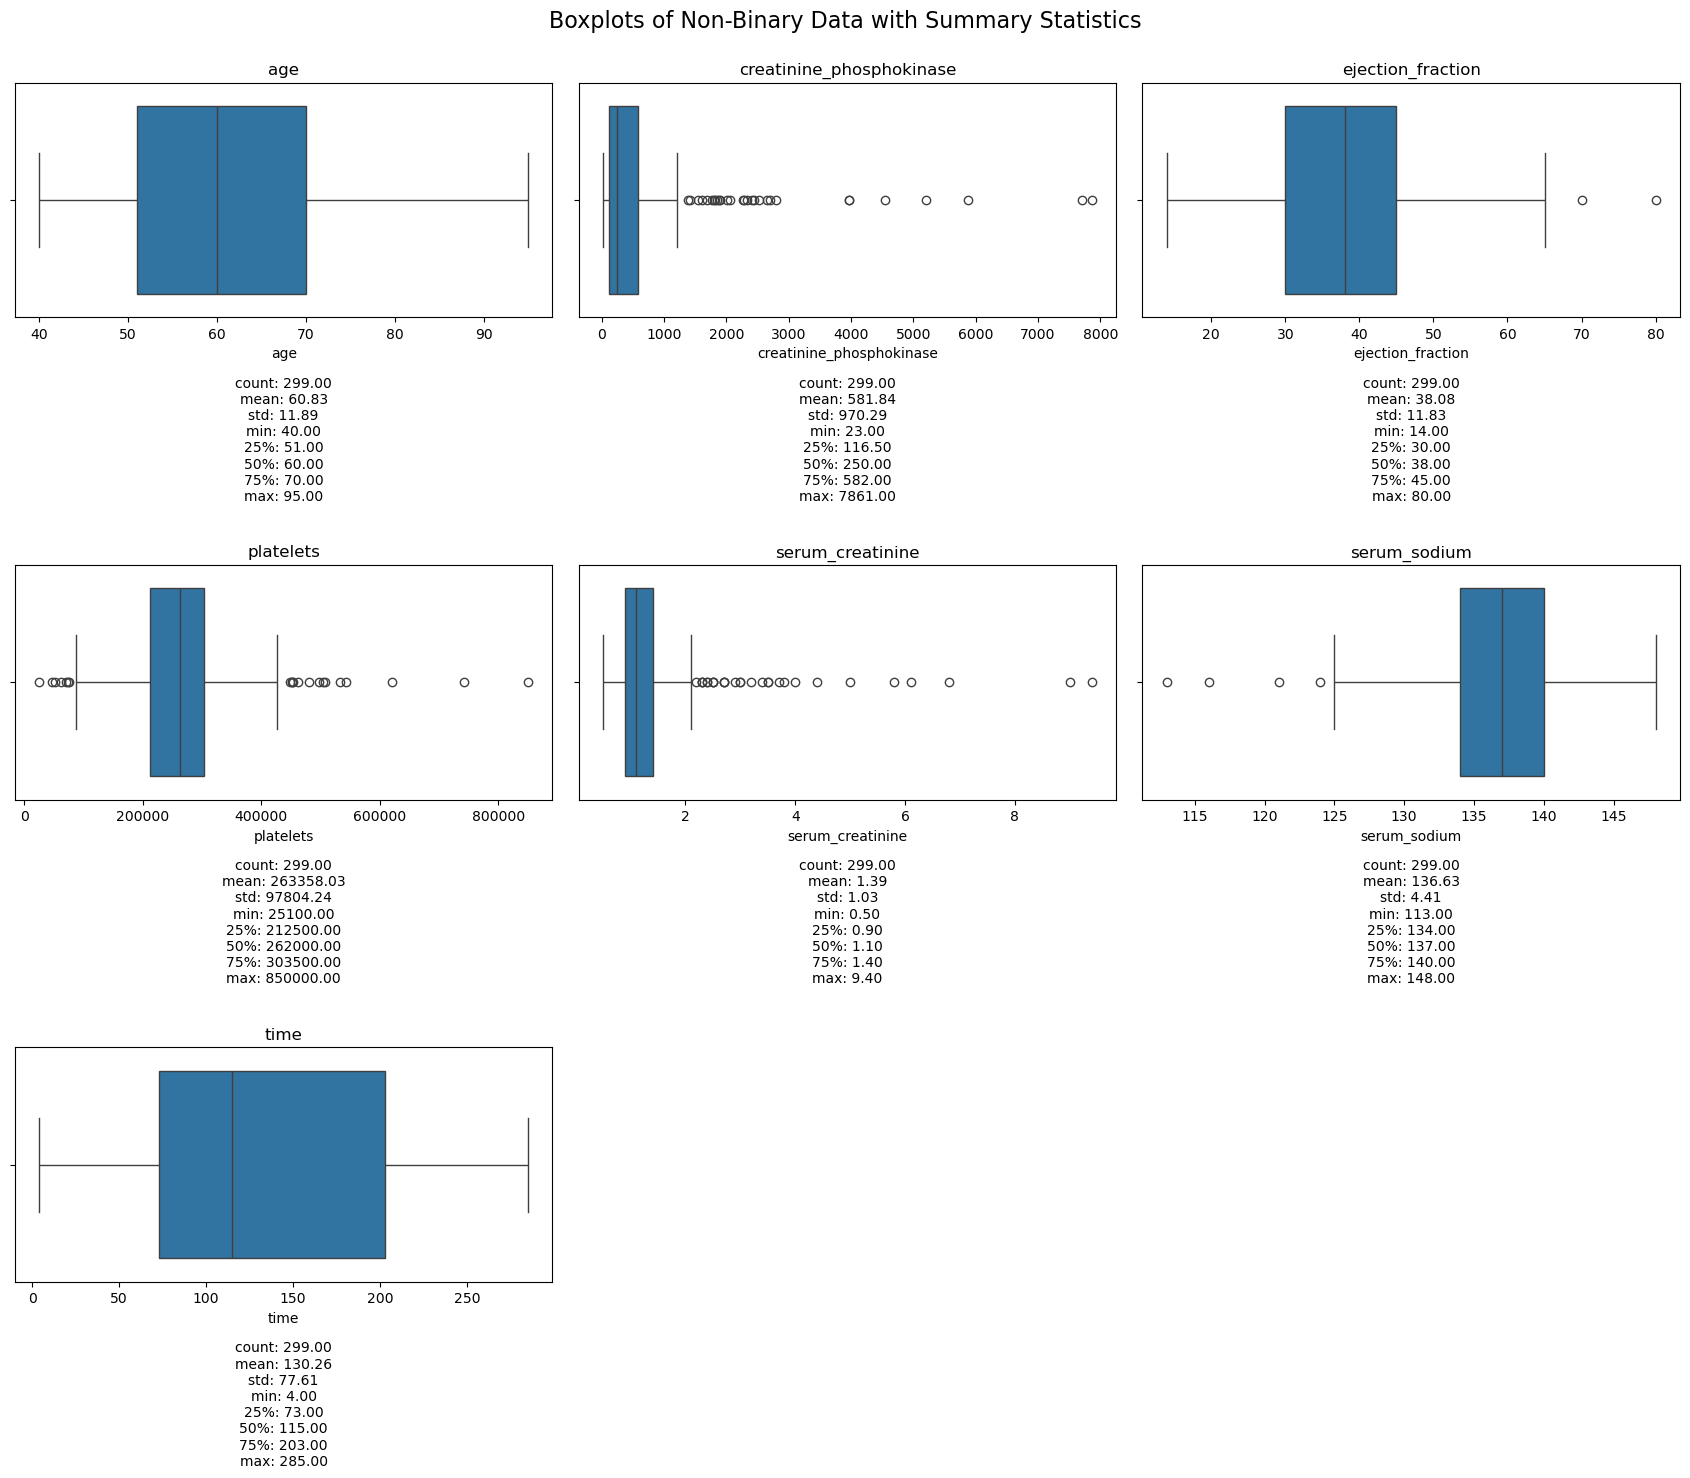

In [5]:
# Boxplots of the non-binary data with summary statistics
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 15))
axes = axes.flatten()

for ax, col in zip(axes, non_binary_data.columns):
    sns.boxplot(x=non_binary_data[col], ax=ax)
    ax.set_title(col)
    
    stats = non_binary_data[col].describe()
    stats_text = '\n'.join([f'{stat}: {val:.2f}' for stat, val in stats.items()])
    
    ax.text(0.5, -0.25, stats_text, fontsize=10, ha='center', va='top', transform=ax.transAxes)

for ax in axes[len(non_binary_data.columns):]:
    ax.set_visible(False)

fig.suptitle("Boxplots of Non-Binary Data with Summary Statistics", fontsize=16, y=1)
plt.tight_layout()
plt.show()


The age variable shows a relatively symmetric distribution centered around 60, with no extreme outliers. Creatinine phosphokinase displays a highly skewed distribution with abnormally high levels. These values could be outliers or the patient may have some health condition impacting its creatinine phosphokinase levels. Ejection fraction has a compact range, centered around 38, with a few extreme values on the higher end, suggesting exceptional cases. Platelets appear normally distributed but with some extreme values far from the central mass, potentially reflecting abnormal conditions. Serum creatinine shows a skewed distribution with notable outliers, implying, once again, rare cases with very high levels. Serum sodium has a more symmetric distribution centered around 137, with mild levels on the lower end. Finally, time is uniformly spread over its range, without significant skewness or outliers, suggesting consistent time observations across patients.

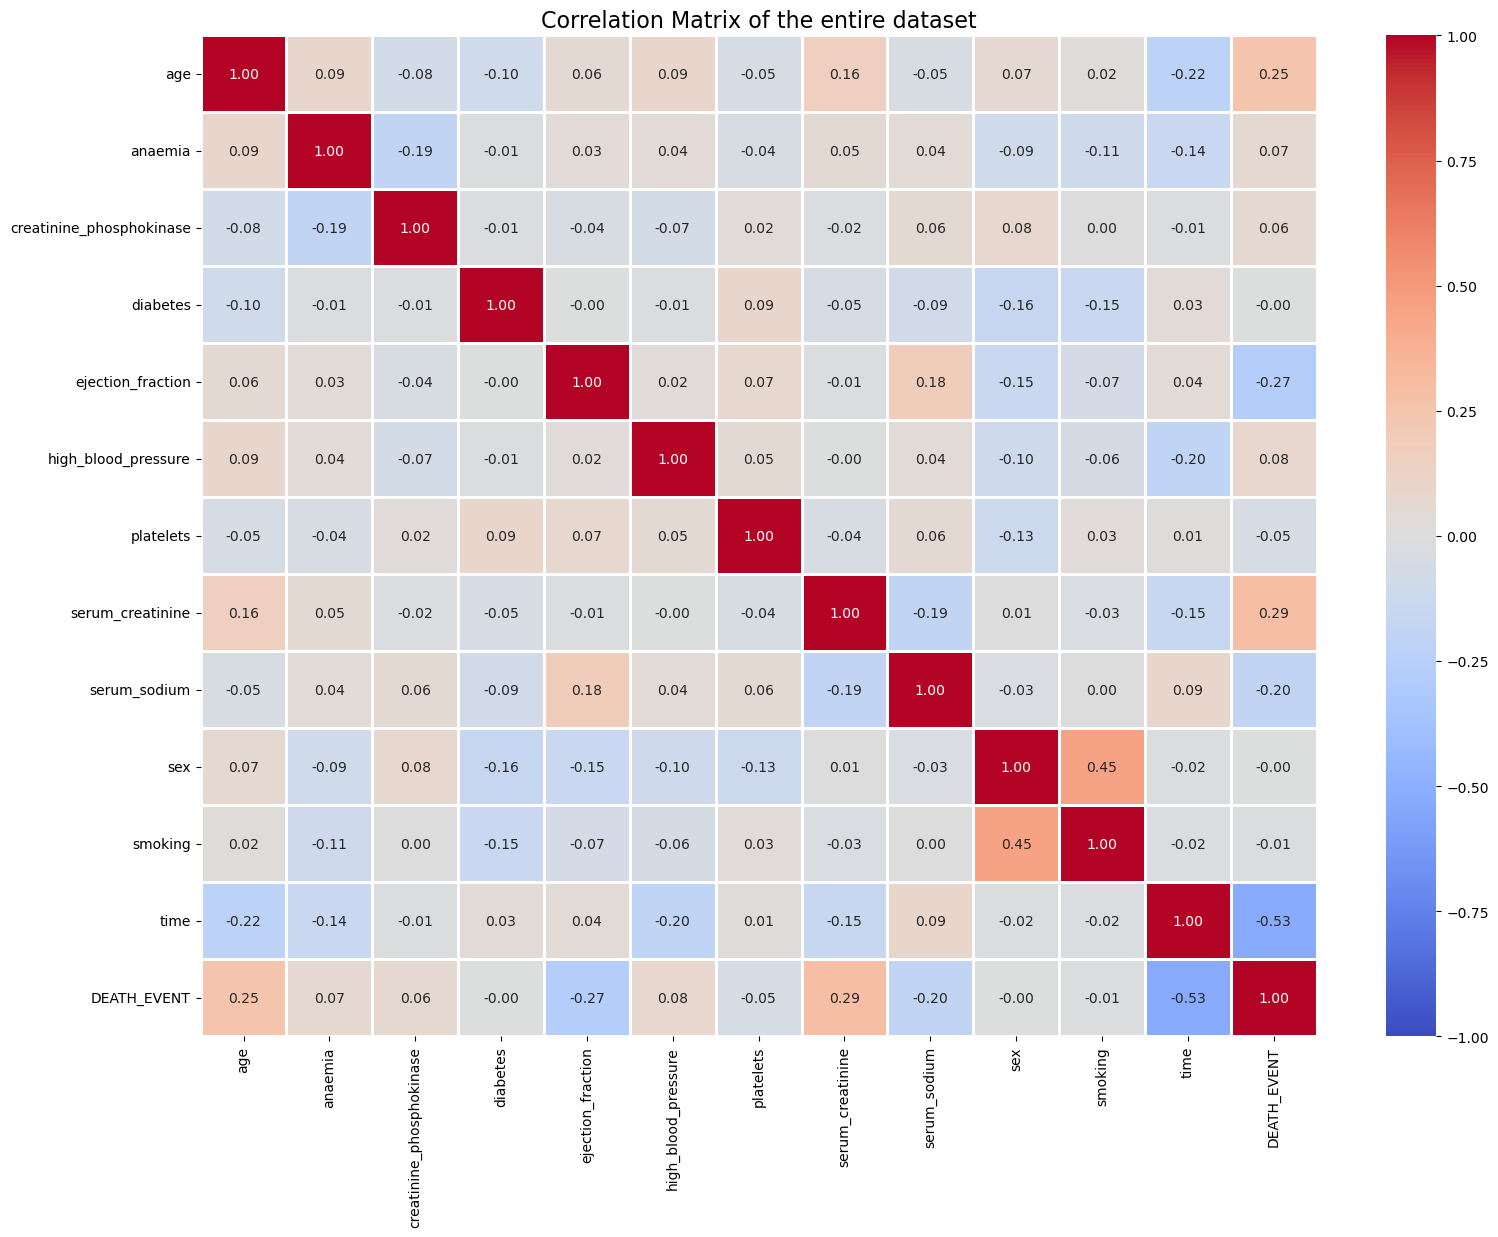

In [6]:
#correlation matrix
corr = data.corr()

plt.figure(figsize=(18, 13))
sns.heatmap(corr, linewidths=1, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix of the entire dataset", fontsize=16)
plt.show()

Age shows a moderate positive correlation with DEATH_EVENT (0.25) and a negative correlation with time (−0.22), indicating that older patients are more likely to die sooner. Serum creatinine exhibits the strongest positive correlation with DEATH_EVENT (0.29), suggesting its importance as a predictive feature. Ejection fraction has a notable negative correlation with DEATH_EVENT (−0.27), implying that lower ejection fractions are associated with higher mortality risk. Time has a strong negative correlation with DEATH_EVENT (−0.53), showing that longer survival times are inversely related to death events, as expected. Those features would certainly be the most important ones to use in a model that studies DEAT_EVENT, meaning that dimension reduction discussion could be useful but is beyond the purpose of this analysis.

Other features, such as high blood pressure, platelets, and serum sodium, have weaker correlations with DEATH_EVENT, suggesting limited direct influence. Smoking and sex are moderately correlated (0.45), reflecting a demographic association, but their impact on DEATH_EVENT is minimal. Overall, serum creatinine, ejection fraction, and age emerge as the most influential variables related to patient outcomes.

The analysis primarily focused on DEATH_EVENT as it represents the feature of greatest interest.

Number of used observations: 227
Percentage of coverage: 75.92%


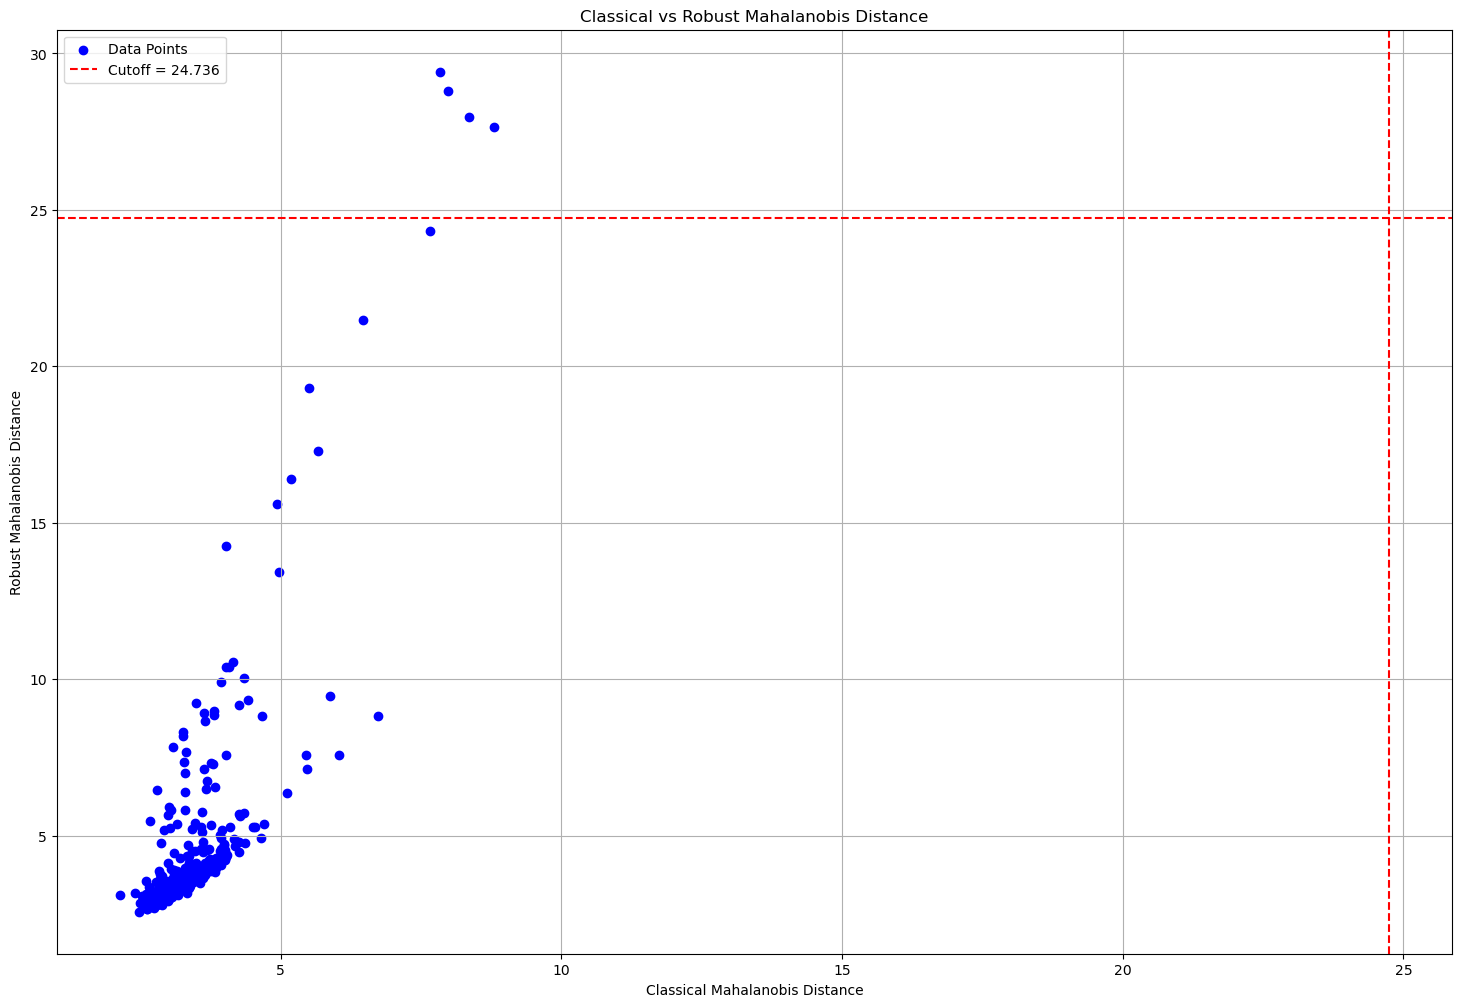

In [7]:
#DD plot of the entire dataset
def compute_mahalanobis(data, robust=False):
    if robust:
        cov_estimator = MinCovDet()
        cov_estimator.fit(data)
        
        used_observations = 0
        for i in range(len(cov_estimator.support_)):
            if cov_estimator.support_[i] == True:
                used_observations += 1
                
        print(f'Number of used observations: {used_observations}')
        print(f'Percentage of coverage: {used_observations / len(data) * 100:.2f}%')
    
        mean = cov_estimator.location_
        cov_inv = np.linalg.inv(cov_estimator.covariance_)
    else:
        mean = data.mean(axis=0)
        cov_inv = np.linalg.inv(np.cov(data, rowvar=False))

    # Compute Mahalanobis distance for each point
    distances = []
    for i in range(len(data)):
        diff = data.iloc[i] - mean
        dist = np.sqrt(np.dot(np.dot(diff, cov_inv), diff.T))
        distances.append(dist)
    
    return np.array(distances)

# Compute classical and robust Mahalanobis distances
classical_md = compute_mahalanobis(data, robust=False)
robust_md = compute_mahalanobis(data, robust=True)

# Set cutoff threshold
cutoff = 24.736

# Plot DD-plot
plt.figure(figsize=(18, 12))
plt.scatter(classical_md, robust_md, c='b', label='Data Points')
plt.axvline(cutoff, color='r', linestyle='--', label=f'Cutoff = {cutoff}')
plt.axhline(cutoff, color='r', linestyle='--')

# Labels and legend
plt.xlabel("Classical Mahalanobis Distance")
plt.ylabel("Robust Mahalanobis Distance")
plt.title("Classical vs Robust Mahalanobis Distance")
plt.legend()
plt.grid(True)
plt.show()


This DD-plot (distance-distance plot) displays the classical Mahalanobis distance on the x-axis and the robust Mahalanobis distance on the y-axis. The key difference between the two lies in how they compute the Mahalanobis distance: the classical method uses the empirical mean and the entire dataset, while the robust method relies on a robust mean calculated from a subset of the data, making it more resistant to the influence of outliers.

To define the cutoff value for identifying outliers, I used the Chi-Squared distribution with a confidence level of 95% and 13 degrees of freedom (corresponding to the number of variables in the dataset). The critical value for this is Chi-Squared(0.975, 13) = 24.736, which serves as the outlier threshold. In the plot, the only potential outliers appear on the robust estimator side, as expected (since the classical method is less sensitive to outliers and may fail to detect them). However, the few points exceeding the threshold cannot be definitively classified as outliers, as the threshold is designed to capture 95% of the data, leaving room for approximately 5% to exceed this limit.

In conclusion, the dataset does not appear to contain significant outliers.

# Build: Probabilistic modelling

### Hazard model

Our goal is to build a survival model to predict the patient likelihood of death by heart failure. 

Formally, we consider a hazard model describing the risk of death at time $t$. We denote the probability of surviving beyond time $t$ as $$S(t) = P(T \geq t),$$ where $T$ is the random variable representing the survival time, that is the duration until death. The instantaneous risk of death at time $t$ having survived up to time $t$ is given by the hazard rate $$h(t) = \lim_{\Delta t \to 0} \frac{P(t \leq T < t + \Delta t | T \geq t)}{\Delta t} = \frac{f(t)}{S(t)},$$ where $f(t)$ is the probability density function of the survival time $T$. Since $f(t) = -\frac{d}{dt}S(t)$, we can relate the hazard rate to the survival function as $$h(t) = \frac{f(t)}{S(t)} = -\frac{1}{S(t)} \frac{d}{dt}S(t) = -\frac{d}{dt} \log(S(t)).$$ By integrating both sides from 0 to $t$, we obtain the cumulative hazard function $$H(t) = \int_0^t h(u) du = -\int_0^t \frac{d}{du} \log(S(u)) du = -[\log(S(t)) - \log(S(0))] = -\log(S(t))$$ since $S(0) = 1$. Therefore, $S(t) = \exp(-H(t))$. 





### Cox proportional hazard model

In this case study, we will use a Cox proportional hazard model to estimate the risk of death by heart failure for a patient with input features $\mathbf{x}$. The Cox model assumes a parametric hazard rate function $$h(t) = h_0(t) \exp(\boldsymbol{\beta}^T \mathbf{x}),$$ where $h_0(t)$ is the baseline hazard and $\boldsymbol{\beta}$ are model parameters. We consider a simple Cox model with a constant baseline hazard $h_0(t) = \lambda$, for which the cumulative hazard is $H(t) = \lambda t \exp(\boldsymbol{\beta}^T \mathbf{x})$ and the survival function is $S(t) = \exp(-\lambda t \exp(\boldsymbol{\beta}^T \mathbf{x}))$.

For a patient $i$ with features $\mathbf{x}_i$ and observed time of death $t_i$, the likelihood $p(t_i | \mathbf{x}_i, \boldsymbol{\beta})$ of observing this event is given by $$p(T=t_i | \mathbf{x}_i, \boldsymbol{\beta}) = h(t_i | \mathbf{x}_i, \boldsymbol{\beta}) S(t_i | \mathbf{x}_i, \boldsymbol{\beta}) = h(t_i | \mathbf{x}_i, \boldsymbol{\beta})  \exp(-H(t_i | \mathbf{x}_i, \boldsymbol{\beta})).$$ If the patient is still alive, then the time of death is not observed yet, and we only know that $T \geq t_i$. In this case, $t_i$ is the time of censoring (i.e., the time at which the medical follow-up ended) and the likelihood is $$p(T \geq t_i | \mathbf{x}_i, \boldsymbol{\beta}) = S(t_i | \mathbf{x}_i, \boldsymbol{\beta}) = \exp(-H(t_i | \mathbf{x}_i, \boldsymbol{\beta})).$$

Overall, if we indicate with $\delta_i = 1$ the event of death and $\delta_i = 0$ the event of censoring, the likelihood for the $i$-th patient is thus given by $$p(t_i | \mathbf{x}_i, \delta_i, \boldsymbol{\beta}) = h(t_i | \mathbf{x}_i, \boldsymbol{\beta})^{\delta_i} \exp(-H(t_i | \mathbf{x}_i, \boldsymbol{\beta})).$$

<div class="alert alert-success">
    
**Q3**. For the case of uncensored data (i.e., $\delta_i = 1$), draw the probabilistic graphical model associated with the Cox model described above. Assume we have $N$ patients in the dataset, each with features $\mathbf{x}_i$ and time of death $t_i$.
    
</div>

The probabilistic graphical model encodes the full joint distribution : 
$$
    p(\mathbf{x}_i, t_i, \beta, \lambda)
$$
and since everybody in the data that we consider is dead ($\delta_i = 1$), we will not write it in our probabilities, it will be implicit.

From the text above we know that the time of death of death $t_i$ is influenced by the features $\mathbf{x}_i$, their weights $\beta$ and that there are the only relations between our variables. Let's do the probabilistic graphical model :

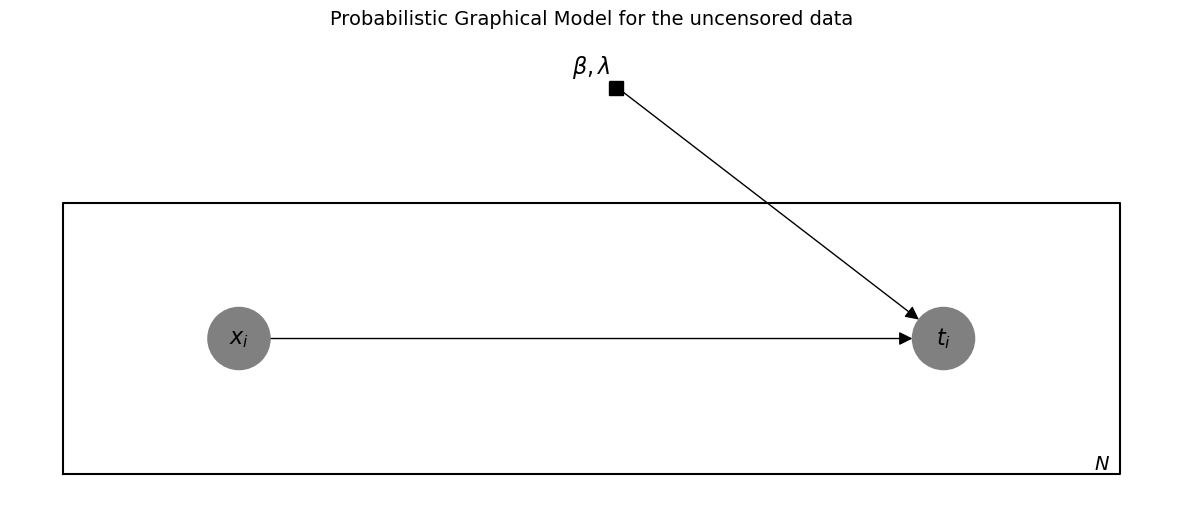

In [8]:
# Create the PGM
fig, ax = plt.subplots(figsize=(15, 6))
pgm = nx.DiGraph()

# Add nodes for global and local variables
pgm.add_node("beta/lamb", pos=(0, 2), label=r"$\beta, \lambda$", color="white")  # Global variable
pgm.add_node("xi", pos=(-1, 1), label=r"$x_i$", color="gray")  # Local latent variable
pgm.add_node("ti", pos=(1, 1), label=r"$t_i$", color="gray")  # Local observed variable

# Add edges for dependencies
pgm.add_edges_from([
    ("beta/lamb", "ti"),
    ("xi", "ti")
])

# Get positions of nodes
pos = nx.get_node_attributes(pgm, 'pos')
labels = nx.get_node_attributes(pgm, 'label')
node_colors = [pgm.nodes[n]["color"] for n in pgm.nodes]

# Plot the graph nodes and edges
nx.draw(pgm, pos, with_labels=True, labels=labels, node_size=[1000, 2000, 2000],
        node_color=node_colors, font_size=16, font_color='black', font_weight='bold', arrowsize=20, ax=ax)

# Add the box
box_x = [-1.5, 1.5, 1.5, -1.5, -1.5] 
box_y = [0.5, 0.5, 1.5, 1.5, 0.5]
ax.plot(box_x, box_y, color="black", lw=1.5)

square = patches.Rectangle((0.05, 1.9), 0.04, 0.05, color="black")
ax.add_patch(square)

ax.text(1.45, 0.5, r"$N$", fontsize=14, ha="center", va="bottom")

plt.title("Probabilistic Graphical Model for the uncensored data", fontsize=14)
plt.show()


Therefore, using the graph, for the uncensored model, the joint probability is given by :
$$
\begin{align*}
    p(\beta, \{\mathbf{x}_i, t_i\}^N_{i=1}) = p(\beta) \hspace{0.1 cm} p(\lambda) \prod^N_{i=1} p(\mathbf{x}_i) \hspace{0.1 cm} p(t_i | \mathbf{x}_i, \beta, \lambda)
\end{align*}
$$

<div class="alert alert-success">
    
**Q4**. Implement the (conditional) model described above (i.e., the prior, the likelihood, as well as a sampler). For the time being, consider an uninformative prior for the model parameters. 

_Tips_: 
Notice that for our choice of baseline hazard $h_0(t) = \lambda$, the cumulative hazard is $H(t) = \lambda t \exp(\boldsymbol{\beta}^T \mathbf{x}) = \lambda t \, c(\mathbf{x}; \boldsymbol{\beta})$ for $c(\mathbf{x}; \boldsymbol{\beta}) = \exp(\boldsymbol{\beta}^T \mathbf{x})$. Therefore, the probability density function of the survival time is $f(t) = h(t) S(t) = \lambda c(x; \boldsymbol{\beta}) \exp(-\lambda t c(\mathbf{x}; \boldsymbol{\beta}))$, which corresponds to an Exponential distribution with rate $\lambda c(\mathbf{x}; \boldsymbol{\beta})$. 

</div>

In [9]:
uncensored_data = data[data['DEATH_EVENT'] == 0].copy()

def uniformative_prior(nb_samples):
    return [1] * nb_samples + [1]


def lambda_prior():
    return abs(uniform.rvs(loc=0.0045, scale=0.0045))

def beta_prior(nb_samples):
    return abs(norm.rvs(loc=0.0, scale=10**(-10), size=nb_samples))


def prior(nb_samples):
    return lambda_prior() * beta_prior(nb_samples)

def log_prior(nb_samples):
    return np.log(lambda_prior()) + np.sum(np.log(beta_prior(nb_samples)))


def likelihood(x, t, delta, params):
    beta = params[:-1]
    lamb = params[-1]
    
    if(lamb <= 0):
        lamb = np.nextafter(0, 1)

    product = np.dot(x, beta)

    return ((lamb * np.exp(product))**delta) * np.exp(-lamb * np.exp(product) * t)

def log_likelihood(x, t, delta, params):
    return np.sum(np.log(likelihood(x, t, delta, params)))


def posterior(x, t, delta, beta, lamb):
    nb_samples = len(beta)
    return likelihood(x, t, delta, beta, lamb) * prior(nb_samples)
 
def log_posterior(params, x, t, delta):
    nb_samples = len(params) - 1
    
    return log_likelihood(x, t, delta, params) + log_prior(nb_samples)


def prior_sampler(nb_samples):
    beta_samples = beta_prior(nb_samples)
    lamb_sample = lambda_prior()
    
    return beta_samples, lamb_sample

<div class="alert alert-success">
    
**Q5**. Using a prior predictive check, evaluate and discuss if the prior predictive distribution is realistic. Propose a weakly informative prior that results in more realistic simulated data.

_Tips_: Plot the survival function $S(t)$ for different parameter samples drawn from the prior.
    
</div>

C:\Users\rober\AppData\Local\Temp\ipykernel_9552\1877960194.py:5: RuntimeWarning: overflow encountered in exp
  return np.exp(-t * lamb * np.exp(linear_combination))


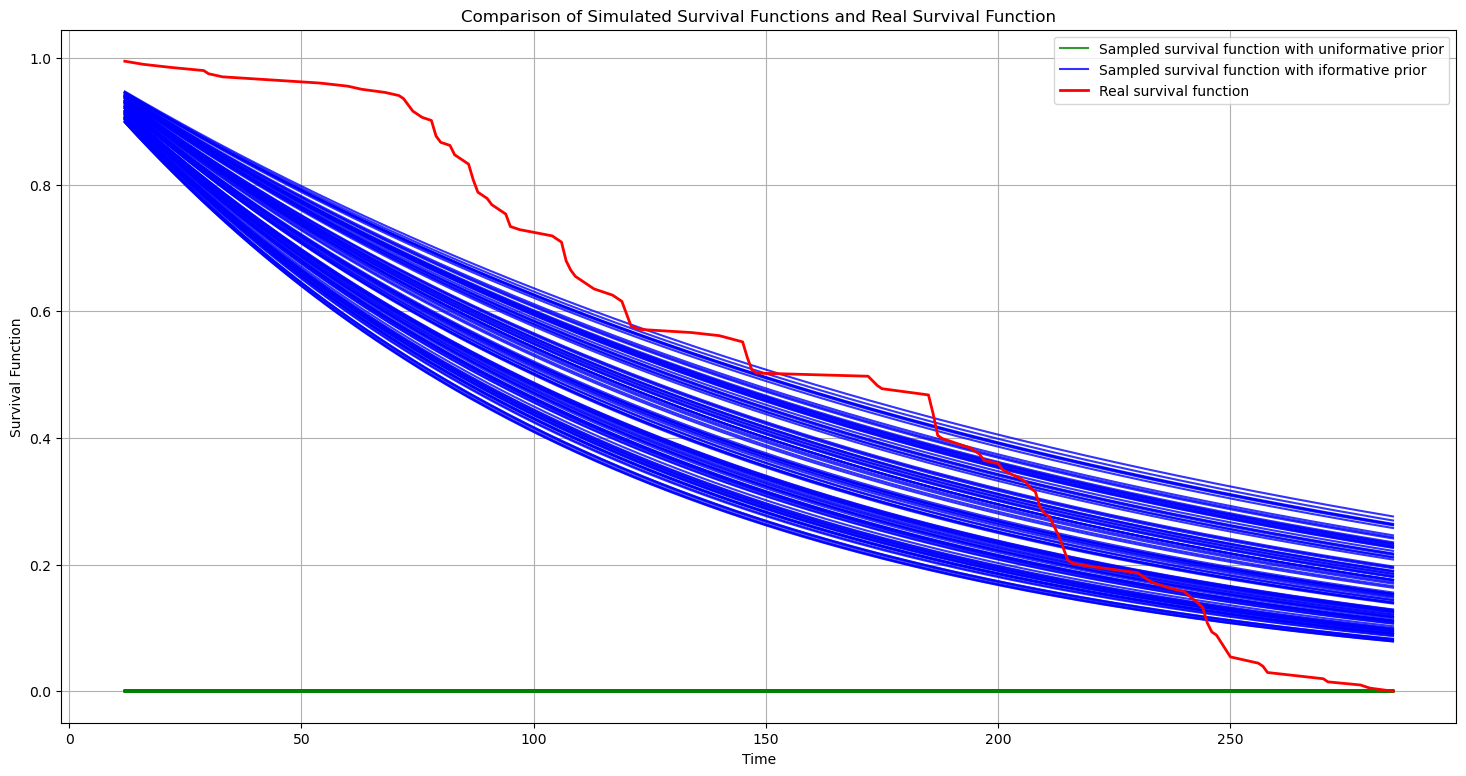

In [10]:
size = 100

def S_t(x, t, beta, lamb):
    linear_combination = x @ beta
    return np.exp(-t * lamb * np.exp(linear_combination))

t = uncensored_data['time'].values
x = uncensored_data[uncensored_data.columns].values

sample_t = np.linspace(t.min(), t.max(), len(x))
unique_t = np.unique(t)
real_S = []

tot_alive = np.sum(uncensored_data['DEATH_EVENT'] == 0)
alive = tot_alive
for time_point in unique_t:
    alive -= np.sum((data['time'] == time_point) & (data['DEATH_EVENT'] == 0))
    real_S.append(alive / tot_alive)
real_S = np.array(real_S)

plt.figure(figsize=(18, 9))
for _ in range(size):
    prior = uniformative_prior(x.shape[1])
    beta1 = prior[:-1]
    lamb1 = prior[-1]
    S_uniformative = S_t(x, sample_t, beta1, lamb1)
    
    beta, lamb = prior_sampler(x.shape[1])
    S_informative = S_t(x, sample_t, beta, lamb)
    
    if _ == 0:
        plt.plot(sample_t, S_uniformative, color='green', alpha=0.8, label='Sampled survival function with uniformative prior')
        plt.plot(sample_t, S_informative, color='blue', alpha=0.8, label='Sampled survival function with iformative prior')
    else:
        plt.plot(sample_t, S_uniformative, color='green', alpha=0.8)
        plt.plot(sample_t, S_informative, color='blue', alpha=0.8)

plt.plot(unique_t, real_S, color='red', label='Real survival function', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Survival Function')
plt.title('Comparison of Simulated Survival Functions and Real Survival Function')
plt.legend()
plt.grid(True)
plt.show()


The plot illustrates the behavior of survival functions generated using two priors, uninformative (green curve) and informative (blue curves), compared to the real survival function (red curve). The uninformative prior results in a flat survival function that stays at zero across all time points, indicating that it completely fails to capture the underlying data distribution. This suggests that the uninformative prior is overly simplistic, using fixed values (β=1, λ=1) that do not account for variability or uncertainty, making it unsuitable for modeling survival functions in this context.

The informative prior produces a spread of survival functions, represented by the blue curves, which generally follow the trend of the real survival function. These curves reflect the uncertainty introduced by the prior and demonstrate its ability to capture meaningful variability. However, the spread is overly concentrated compared to the real survival function, indicating that the prior may still be too restrictive. These priors may require some adjustments, but they are sufficient for now.

# Compute: Posterior inference

<div class="alert alert-success">
    
**Q6a**. Using as input features $\mathbf{x}$ the binary variable `high_blood_pressure`, the death or censoring time `time`, and the event indicator `DEATH_EVENT`, compute the posterior distribution of all unobserved random variables.
    
_Tips_: If you use MCMC, initialize the chain(s) around the MAP estimate.
    
</div>

In [11]:
def neg_log_posterior(params, x, t, delta):
    return -np.sum(log_posterior(params, x, t, delta))

t_keep = data['time'].values
x_keep = data[['high_blood_pressure']].values
deltas = data['DEATH_EVENT'].values
nb_features = x_keep.shape[1]

nwalkers = 100
ndim = nb_features + 1

beta_init, lambda_init = prior_sampler(nb_features)
x0 = np.append(beta_init, lambda_init)

# MAP estimation
result = minimize(neg_log_posterior, 
                    x0=x0, 
                    args=(x_keep, t_keep, deltas),
                    method='Powell',
                    bounds=[(np.nextafter(0, 1), 10**(-8)), (np.nextafter(0, 1), 0.1)])

best_function_value = result.fun
best_result = result.x

print(f"Best function value: {best_function_value}")
print(f"Best result: {best_result}")

Best function value: 700.9078024262228
Best result: [3.81966011e-09 2.77278672e-03]


Best result gives our initial predictions for MCMC

In [12]:
# MCMC
nb_steps = 10000
initial = np.zeros((nwalkers, ndim))

for i in range(nwalkers):
    initial[i, :-1] = best_result[0] + 1e-11 * np.random.uniform(0, 1, size=nb_features)
    initial[i, -1] = best_result[1] + 1e-4 * np.random.uniform(0, 1)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_keep, t_keep, deltas))
sampler.run_mcmc(initial, nb_steps, progress=True)

100%|██████████| 10000/10000 [00:54<00:00, 182.20it/s]


State([[ 0.75998331  0.00183015]
 [ 0.66745606  0.00169727]
 [ 0.13643315  0.00228958]
 [ 0.52825822  0.00193896]
 [ 0.88182115  0.00159322]
 [ 0.38289696  0.00204891]
 [ 0.46501103  0.0019859 ]
 [ 0.51688474  0.00224242]
 [ 0.6438404   0.00168004]
 [ 0.24780172  0.00220804]
 [ 0.41323081  0.00213287]
 [ 0.73975102  0.00179937]
 [ 0.39692654  0.00220246]
 [ 0.58024328  0.00210806]
 [ 0.47392886  0.00198413]
 [ 0.2394974   0.00224927]
 [ 0.3905945   0.0020087 ]
 [ 0.7615978   0.0021002 ]
 [ 0.50944138  0.00230614]
 [ 0.59963236  0.00257019]
 [ 0.61733007  0.00196464]
 [ 0.31965152  0.00212659]
 [ 0.73484999  0.0021516 ]
 [ 0.51463796  0.0022835 ]
 [ 0.63095212  0.00205162]
 [ 0.69974914  0.00172819]
 [ 0.20554957  0.00227719]
 [ 0.70927972  0.00177011]
 [ 0.48127001  0.00154258]
 [ 0.37631913  0.00210312]
 [ 0.28274217  0.0018972 ]
 [ 0.46279938  0.00223484]
 [ 0.44733357  0.0023011 ]
 [ 0.37611812  0.00247748]
 [ 0.01160214  0.00269118]
 [ 0.33857242  0.00257201]
 [ 0.05386591  0.00253

<div class="alert alert-success">
    
**Q7a**. Assess whether your inference results are computationally faithful (check the convergence, mixing, and autocorrelation of the chains).
    
</div>

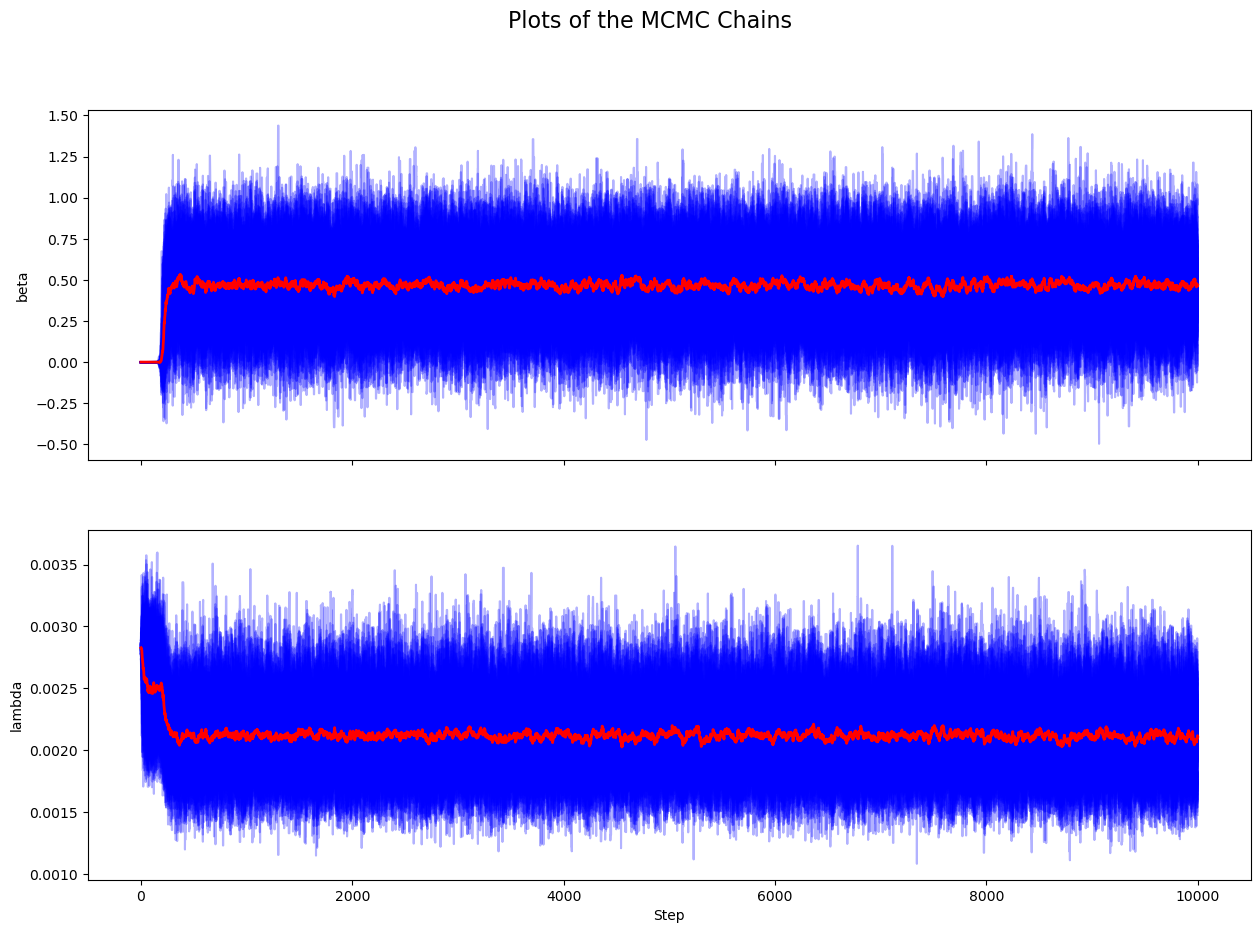

In [13]:
samples = sampler.get_chain()

fig, axes = plt.subplots(nrows=ndim, ncols=1, figsize=(15, 10), sharex=True)
labels = ['beta', 'lambda']
for i in range(ndim):
    axes[i].plot(samples[:, :, i], color='blue', alpha=0.3)
    axes[i].set_ylabel(labels[i])
    axes[i].plot(np.mean(samples[:, :, i], axis=1), color='red', linewidth=2)

axes[-1].set_xlabel("Step")
plt.xlabel("Step")
plt.suptitle("Plots of the MCMC Chains", fontsize=16)
plt.show()


In [14]:
tau = sampler.get_autocorr_time()
print(f"Autocorrelation time: {tau}")

Autocorrelation time: [64.32548888 55.47953543]


The MCMC chains for both β (top) and λ (bottom) show good stability over time. The red line, representing the running mean of the samples, stabilizes quickly, indicating that the chains have likely converged to the stationary distribution. Additionally, the lack of systematic trends in the chains (like an upward/downward movement) after the on in the beginning, supports convergence.

The chains exhibit reasonable mixing, as evidenced by the high frequency of oscillations and the absence of flat regions or prolonged periods without significant changes. This suggests that the sampler explores the posterior space effectively and avoids getting stuck in local modes.

The computed autocorrelation times (∼ 64 for β and ∼ 55 for λ) indicate that the samples are quickly lose their correlation. This level of autocorrelation is acceptable especially when the high number of steps (10000) is considered.

<div class="alert alert-success">
    
**Q8a**. Plot the posterior distributions and discuss the results.
    
</div>

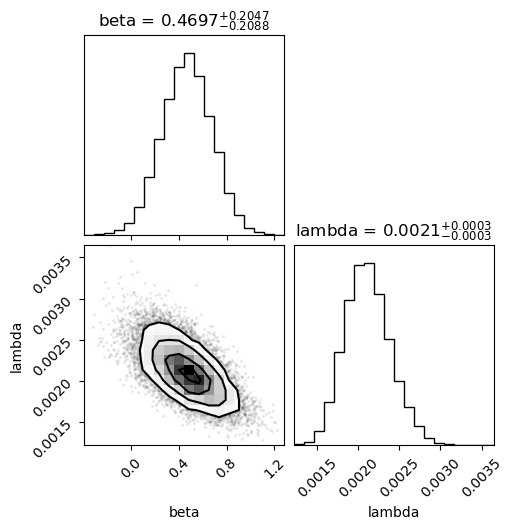

In [15]:
samples = sampler.get_chain(discard=1000, thin=int(np.max(tau))+1, flat=True)

fig = corner.corner(samples, labels=labels, show_titles=True, title_fmt=".4f", title_kwargs={"fontsize": 12})

The posterior distributions for both β and λ exhibit well-defined shapes:
- β has a symmetric distribution centered around 0.4695, suggesting a positive relationship between high_blood_pressure and survival in this setup. This indicates that high_blood_pressure may have a meaningful positive influence on the survival model.
- λ is centered around 0.0021 with a narrower spread than β. The distribution appears well-defined, with a little bit of skewness, indicating a stable parameter estimation.
The joint posterior density contours (bottom-left plot) reveal a slight positive correlation between β and λ, suggesting that changes in one parameter slightly influence the other. However, this correlation is weak, indicating that the parameters are relatively independent under the current model.

β was sampled from a normal distribution and retains its "normality" in the posterior, but with larger values compared to the prior. This effect may result from the low number of features (only one), which allows β to take on larger weights without causing the exponential term in the likelihood to overflow. On the other hand, λ, which was sampled from a uniform distribution, has maintained its original range of values but has acquired a more "normal-like" shape in the posterior. This suggests that the true distribution of λ, as informed by the data, is closer to a normal distribution rather than uniform.

<div class="alert alert-success">
    
**Q6b, Q7b, Q8b**. Repeat the above steps using instead the binary variable `smoking` as input feature.
    
</div>

In [16]:
new_t_keep = data['time'].values
new_x_keep = data[['smoking']].values
new_deltas = data['DEATH_EVENT'].values
nb_features = new_x_keep.shape[1]

nwalkers = 100
ndim = nb_features + 1

beta_init, lambda_init = prior_sampler(nb_features)
x0 = np.append(beta_init, lambda_init)

result = minimize(neg_log_posterior, 
                  x0=x0, 
                  args=(new_x_keep, new_t_keep, new_deltas),
                  method='Powell',
                  bounds=[(np.nextafter(0, 1), 10**(-8)), (np.nextafter(0, 1), 0.1)])
    
new_best_function_value = result.fun
new_best_result = result.x

print(f"Best function value: {new_best_function_value}")
print(f"Best result: {new_best_result}")

Best function value: 701.6992283535129
Best result: [3.81966011e-09 2.37275847e-03]


In [17]:
nb_steps = 10000
initial = np.zeros((nwalkers, ndim))

for i in range(nwalkers):
    initial[i, :-1] = new_best_result[0] + 1e-11 * np.random.uniform(0, 1, size=nb_features)
    initial[i, -1] = new_best_result[1] + 1e-4 * np.random.uniform(0, 1)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(new_x_keep, new_t_keep, new_deltas))
sampler.run_mcmc(initial, nb_steps, progress=True)

100%|██████████| 10000/10000 [00:57<00:00, 172.85it/s]


State([[-0.02439659  0.00185338]
 [-0.0509951   0.00253502]
 [ 0.21029401  0.00208629]
 [ 0.35703585  0.00238925]
 [ 0.11655448  0.00235427]
 [ 0.1257223   0.00251768]
 [-0.25233031  0.00282231]
 [-0.44557033  0.0024336 ]
 [ 0.02001757  0.00251543]
 [ 0.01817184  0.00235942]
 [ 0.19094093  0.00229994]
 [ 0.15741215  0.00231229]
 [-0.00885165  0.00221591]
 [ 0.12970982  0.00234976]
 [-0.09681761  0.0025294 ]
 [-0.01347526  0.00243822]
 [-0.21618849  0.00312977]
 [ 0.12638673  0.00268745]
 [ 0.08423111  0.00239008]
 [-0.04547958  0.00260879]
 [ 0.10093694  0.00253272]
 [-0.03689133  0.00275501]
 [ 0.19207174  0.00232589]
 [ 0.02338658  0.0024768 ]
 [-0.14750044  0.00307519]
 [ 0.53013623  0.00186398]
 [-0.04535734  0.00234415]
 [-0.04688648  0.00232799]
 [ 0.25349393  0.00290831]
 [-0.06935976  0.00253402]
 [ 0.13360362  0.0026859 ]
 [ 0.00683131  0.00267799]
 [ 0.42856623  0.00224361]
 [ 0.28671192  0.00180468]
 [-0.15976847  0.00227892]
 [-0.1030456   0.00222405]
 [ 0.09415092  0.00220

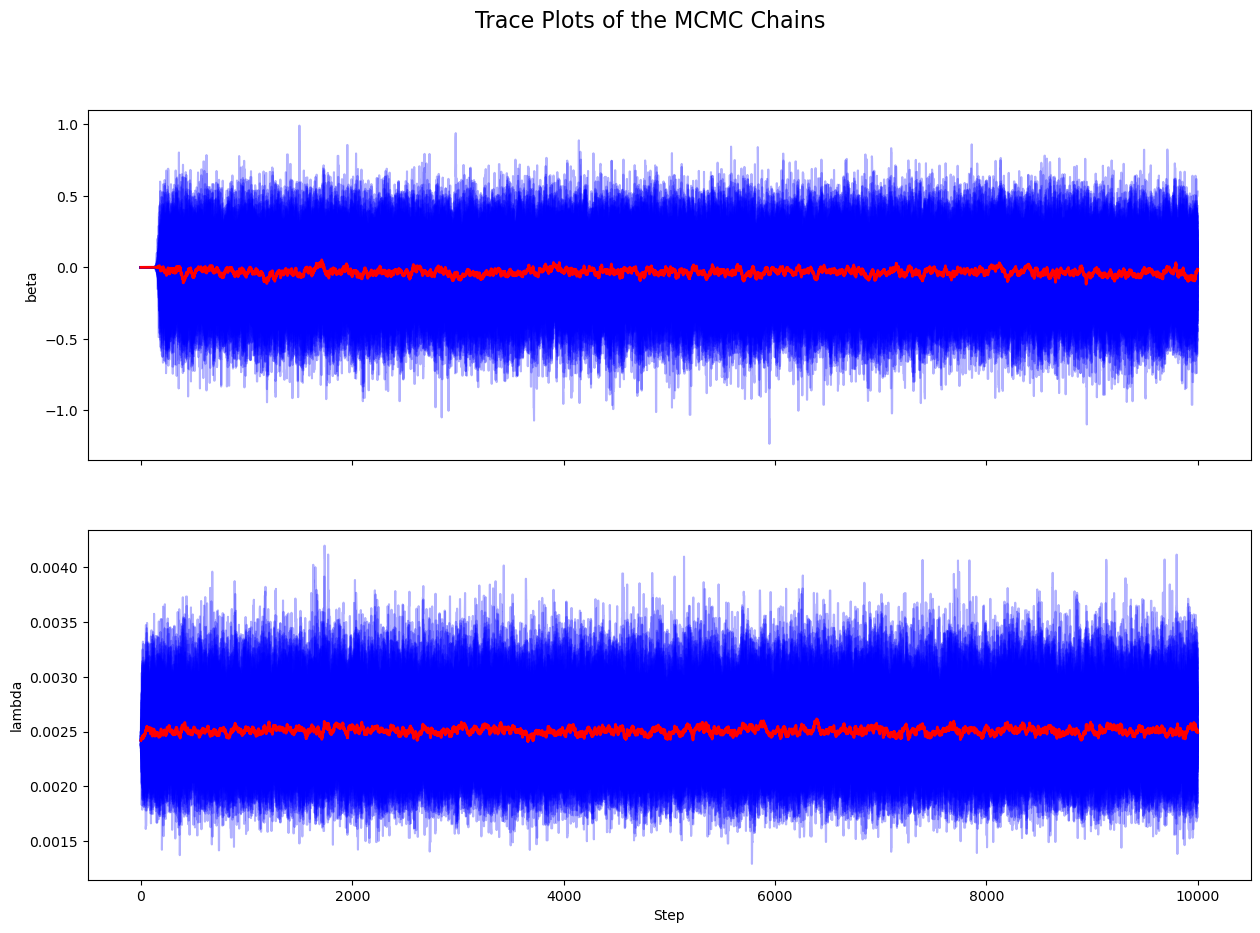

In [18]:
new_samples = sampler.get_chain()

fig, axes = plt.subplots(nrows=ndim, ncols=1, figsize=(15, 10), sharex=True)
labels = ['beta', 'lambda']
for i in range(ndim):
    axes[i].plot(new_samples[:, :, i], color='blue', alpha=0.3)
    axes[i].set_ylabel(labels[i])
    axes[i].plot(np.mean(new_samples[:, :, i], axis=1), color='red', linewidth=2)

axes[-1].set_xlabel("Step")
plt.xlabel("Step")
plt.suptitle("Trace Plots of the MCMC Chains", fontsize=16)
plt.show()

In [19]:
tau = sampler.get_autocorr_time()
print(f"Autocorrelation time: {tau}")

Autocorrelation time: [44.72520045 45.11245654]


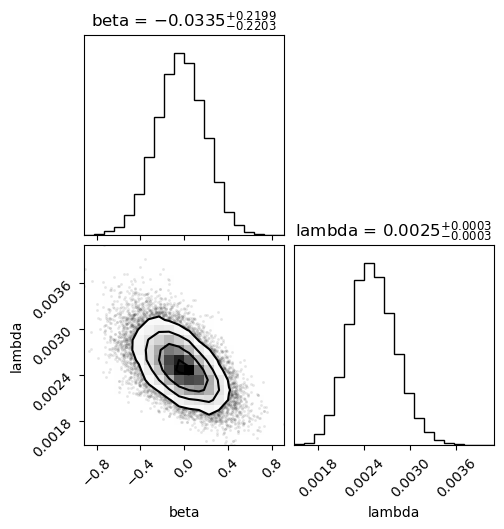

In [20]:
new_samples = sampler.get_chain(discard=1000, thin=int(np.max(tau))+1, flat=True)

fig = corner.corner(new_samples, labels=labels, show_titles=True, title_fmt=".4f", title_kwargs={"fontsize": 12})

The MCMC chains for both β and λ appear stable, with the running mean (red line) stabilizing quickly, indicating good convergence. The chains exhibit effective mixing, with frequent oscillations and no flat regions, showing efficient exploration of the posterior. Autocorrelation times (∼ 44 for β and ∼ 45 for λ) are low when compared to the number of steps, suggesting acceptable sampling efficiency.

The posterior distribution for β has a mean of −0.0284 with intervals indicating an almost zero centered distribution. This could display a lack of relationship between smoking and the survival model. The posterior for λ is centered around 0.0025 and retains a narrow spread. The distribution is normal-like with a range of values consistent with the prior.

# Criticize

<div class="alert alert-success">
    
**Q9**. Evaluate the posterior predictive distribution for the two models and discuss the results.

_Tips_: Plot the survival function $S(t)$ for different parameter samples drawn from the posterior against the empirical survival function of the observed data $\hat{S}(t) = \frac{N(t)}{N}$, where $N(t)$ is the number of patients who survived beyond time $t$.
    
</div>

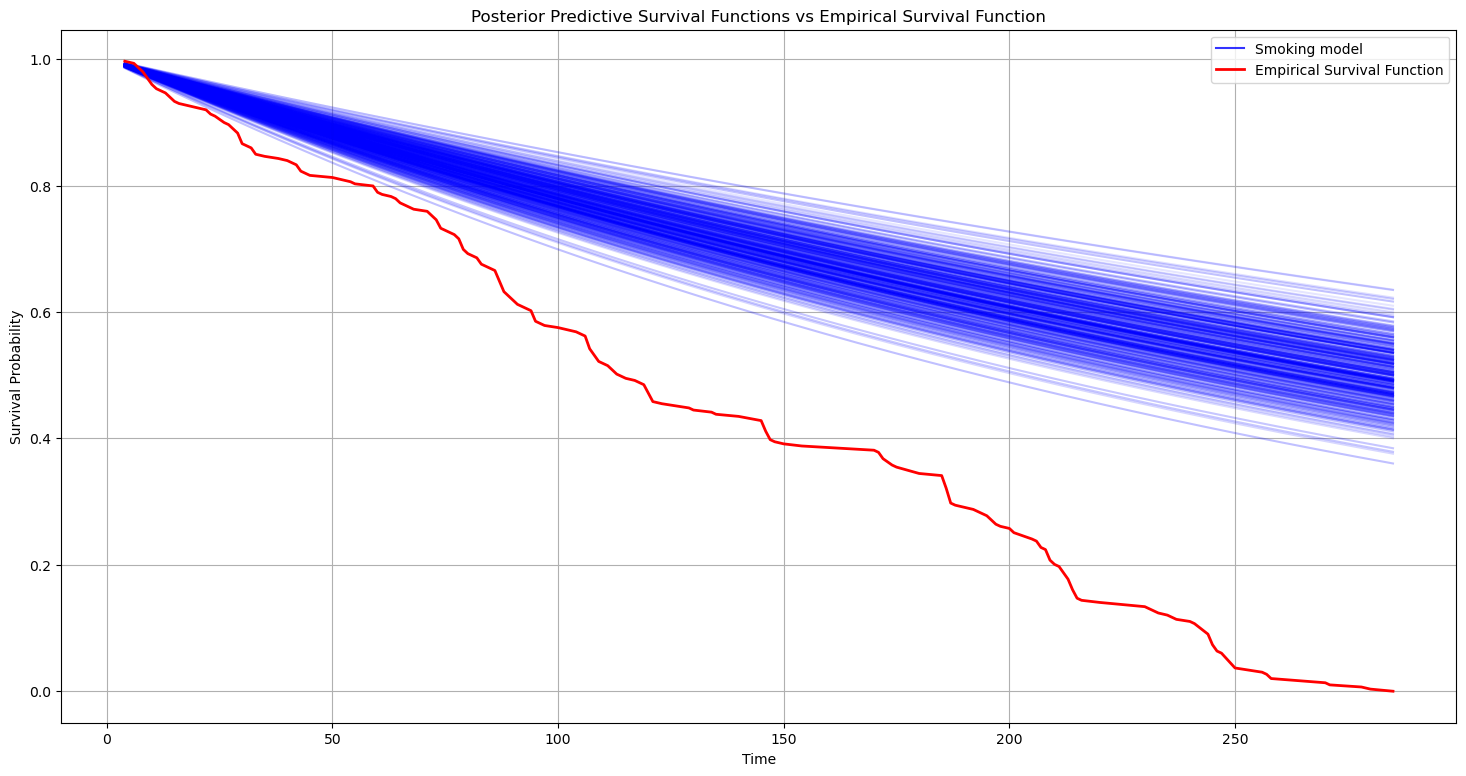

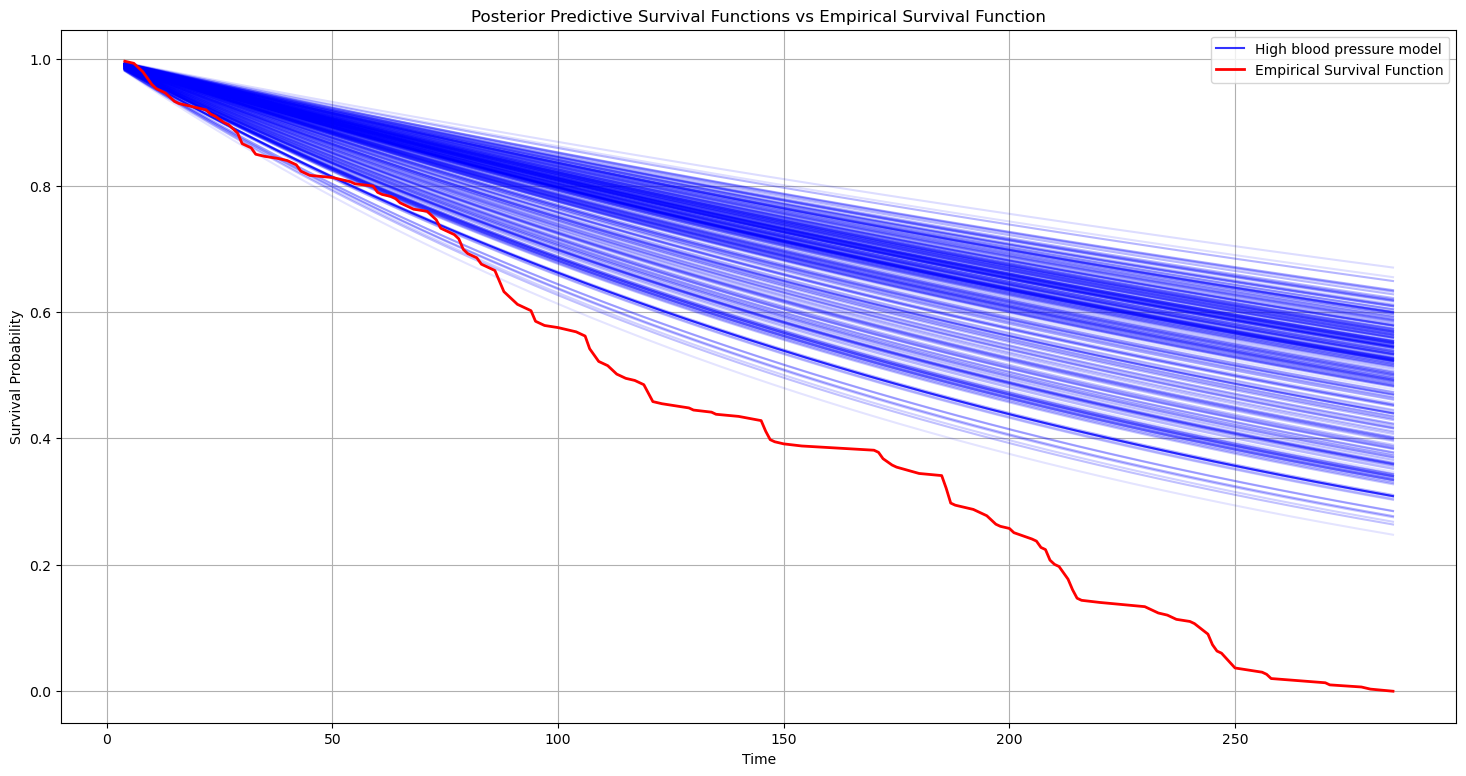

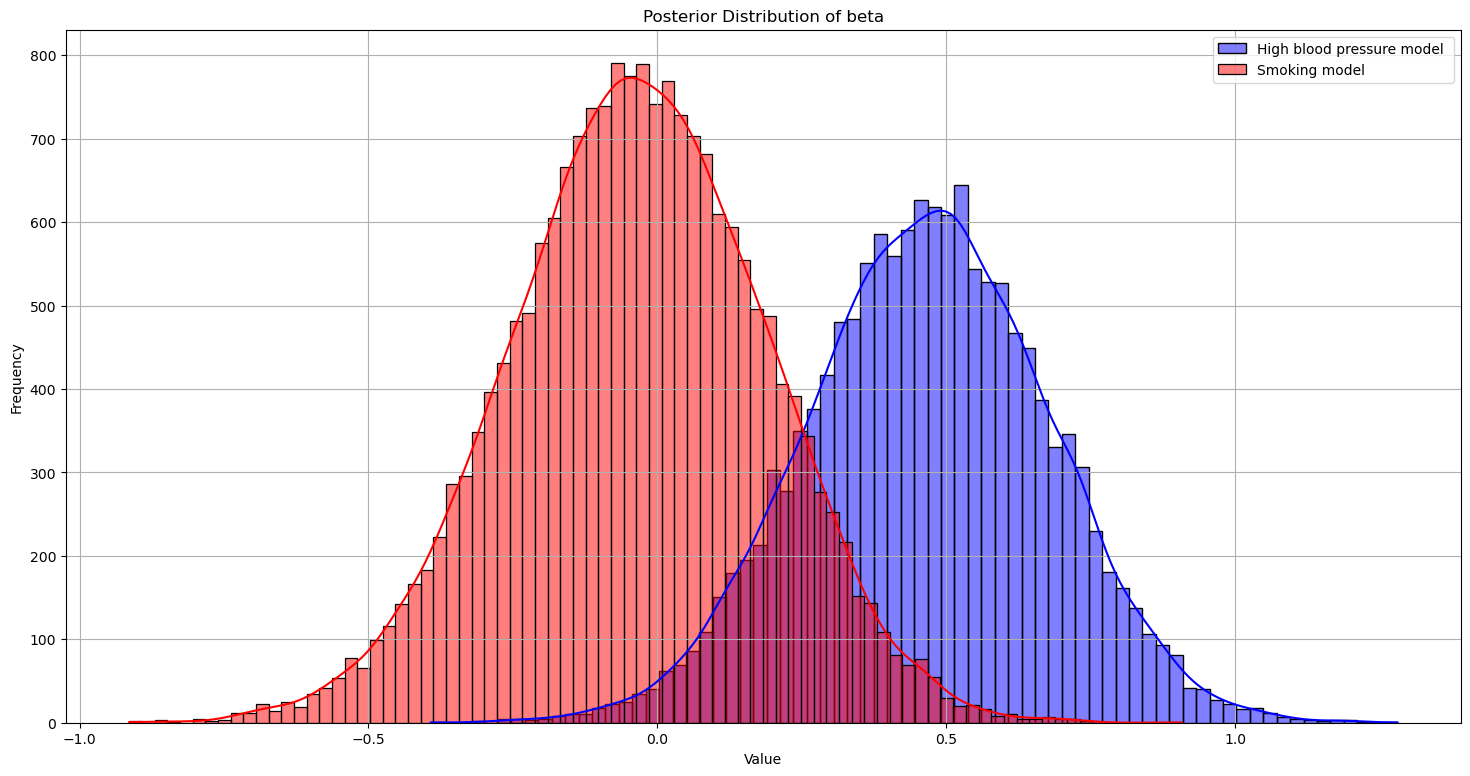

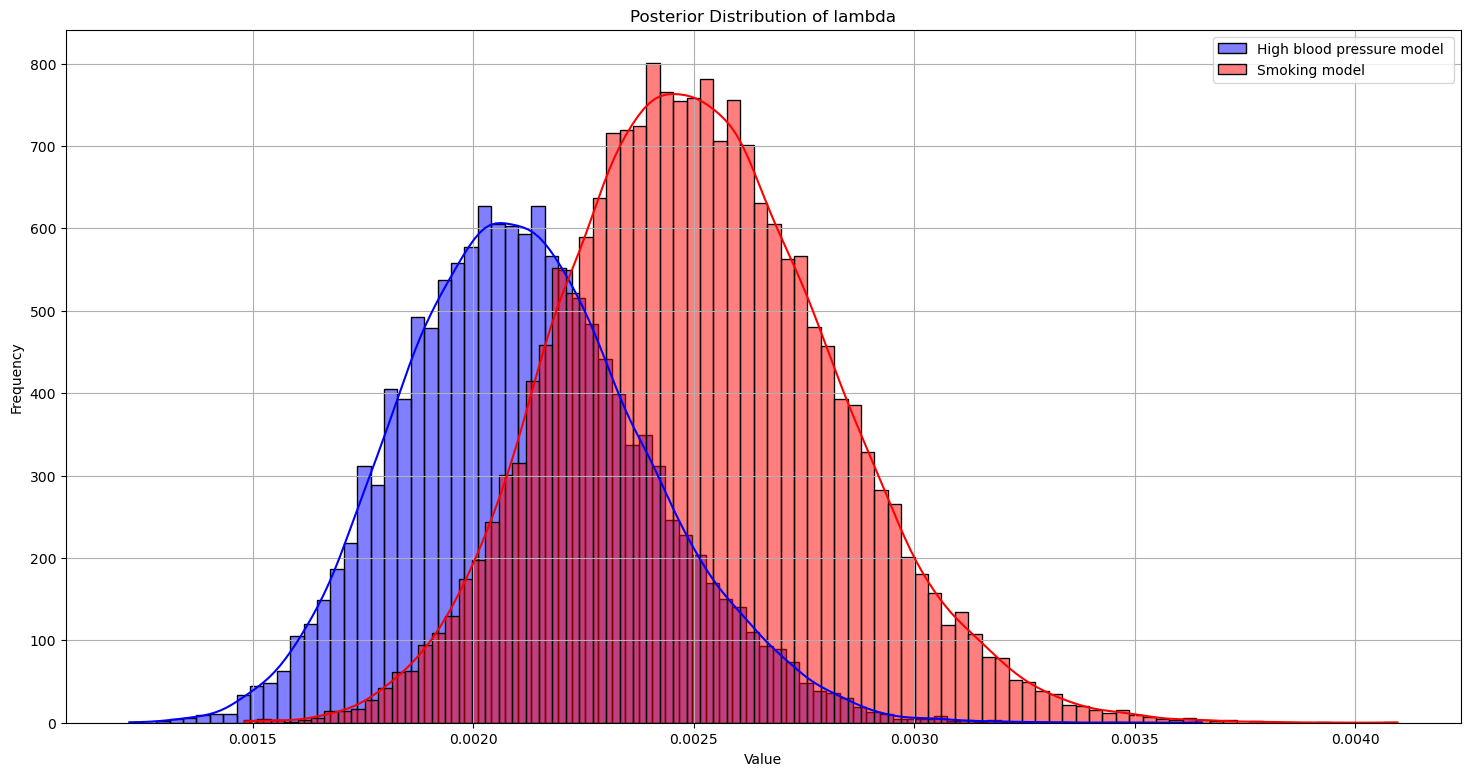

In [24]:
size = new_x_keep.shape[0]
t_range = np.linspace(new_t_keep.min(), new_t_keep.max(), size)
new_S_t_values = []

plt.figure(figsize=(18, 9))
to_plot = 0
for i in range(size):
    beta = new_samples[i*5, :-1]
    lamb = new_samples[i*5, -1]
    
    new_S_t_values.append(S_t(new_x_keep[i], t_range, beta, lamb))
    
    if to_plot == 0:
        plt.plot(t_range, new_S_t_values[i], color='blue', alpha=0.8, label='Smoking model')
        to_plot = 1
    else:
        plt.plot(t_range, new_S_t_values[i], color='blue', alpha=random.uniform(0.1, 0.3))

new_unique_t = np.sort(np.unique(new_t_keep))
N = len(new_t_keep)
empirical_S_t = []
for time_point in new_unique_t:
    N_t = np.sum(t_keep > time_point)
    empirical_S_t.append(N_t / N)

plt.plot(new_unique_t, empirical_S_t, color='red', label='Empirical Survival Function', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Posterior Predictive Survival Functions vs Empirical Survival Function')
plt.legend()
plt.grid(True)
plt.show()

size = x_keep.shape[0]
t_range = np.linspace(t_keep.min(), t_keep.max(), size)
S_t_values = []

plt.figure(figsize=(18, 9))
to_plot = 0
for i in range(size):
    beta = samples[i*5, :-1]
    lamb = samples[i*5, -1]
    
    S_t_values.append(S_t(x_keep[i], t_range, beta, lamb))
    
    if to_plot == 0:
        plt.plot(t_range, S_t_values[i], color='blue', alpha=0.8, label='High blood pressure model')
        to_plot = 1
    else:
        plt.plot(t_range, S_t_values[i], color='blue', alpha=random.uniform(0.1, 0.3))

unique_t = np.sort(np.unique(t_keep))

plt.plot(unique_t, empirical_S_t, color='red', label='Empirical Survival Function', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Posterior Predictive Survival Functions vs Empirical Survival Function')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(18, 9))
sns.histplot(samples[:, 0], color='blue', alpha=0.5, label=f'High blood pressure model ', kde=True)
sns.histplot(new_samples[:, 0], color='red', alpha=0.5, label=f'Smoking model', kde=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Posterior Distribution of beta')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 9))
sns.histplot(samples[:, 1], color='blue', alpha=0.5, label=f'High blood pressure model ', kde=True)
sns.histplot(new_samples[:, 1], color='red', alpha=0.5, label=f'Smoking model', kde=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Posterior Distribution of lambda')
plt.legend()
plt.grid(True)
plt.show()

The smoking model's sampled survival functions show a tighter band, indicating lower variability, but weaker alignment with the empirical survival function, especially for longer survival times. This suggests the model struggles to capture the full range of survival probabilities. In contrast, the high_blood_pressure model exhibits greater variability, aligning better with the empirical survival function for medium survival times, though it lacks precision for higher survival times.

The posterior distributions of β offer further insights. For the high_blood_pressure model, β has a positive mean, indicating a meaningful positive association with survival, consistent with its better predictive performance. The smoking model, however, has β centered near zero, suggesting minimal impact on survival predictions. Additionally, the smoking model's λ distribution is centered around a higher value than the high_blood_pressure model's, indicating a higher baseline hazard rate, despite β's negligible influence on survival.

Overall, the high_blood_pressure model outperforms the smoking model, demonstrating better predictive accuracy and alignment with the empirical survival function.

<div class="alert alert-success">
    
**Q10**. Evaluate the posterior predictive distributions of test quantities of replicated data and discuss the results.
    
</div>

c:\Users\rober\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rober\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rober\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


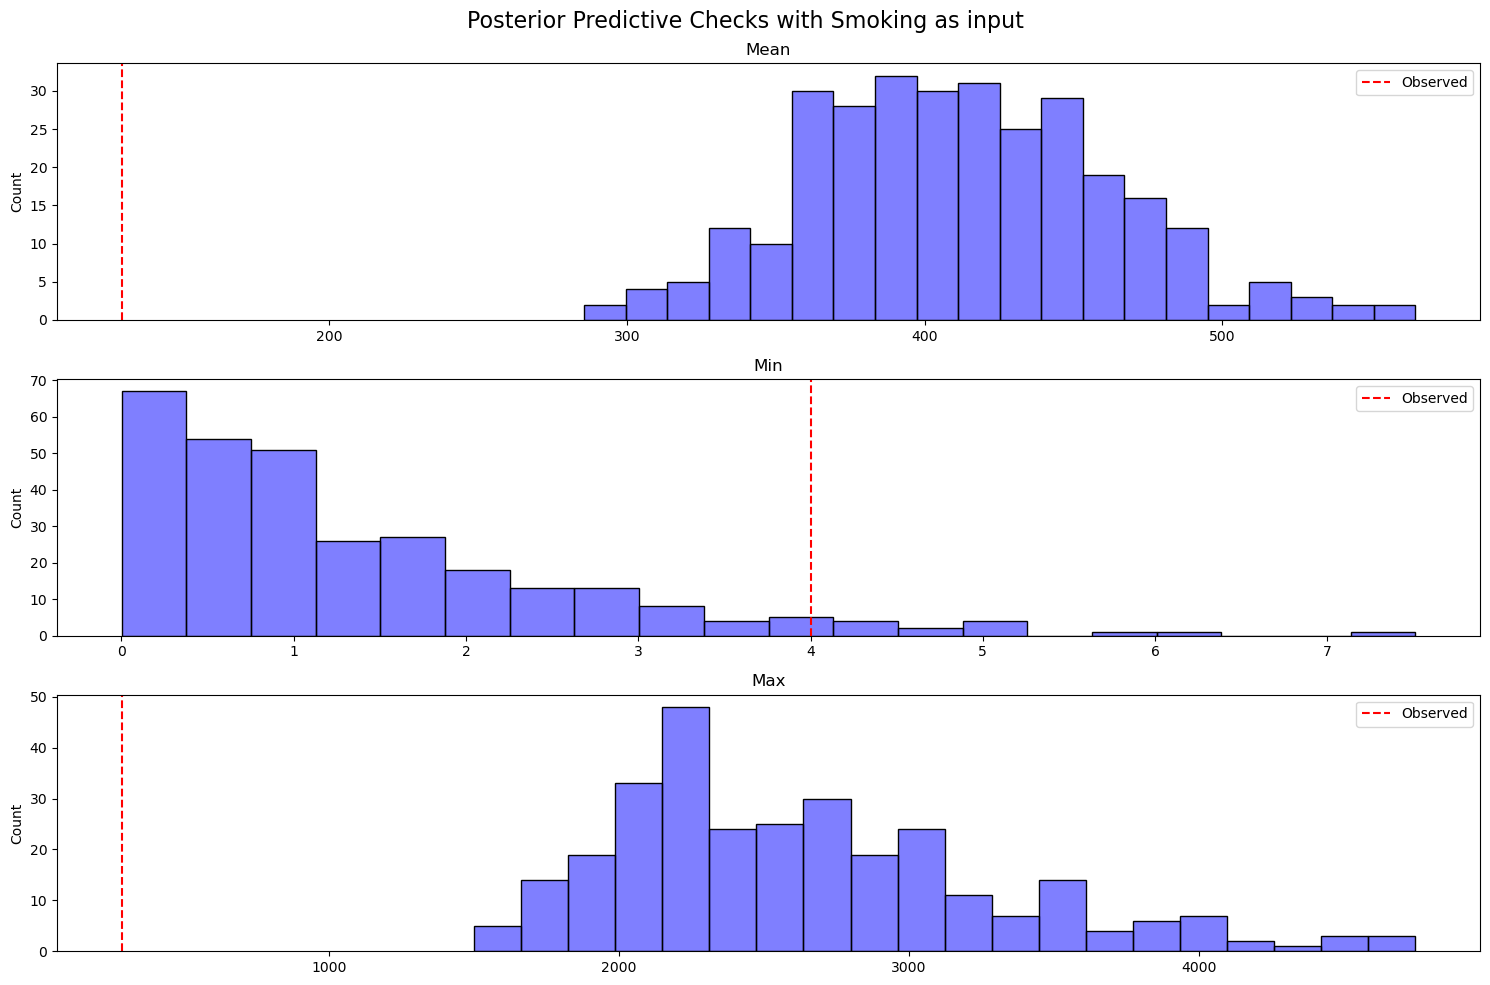

c:\Users\rober\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rober\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rober\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


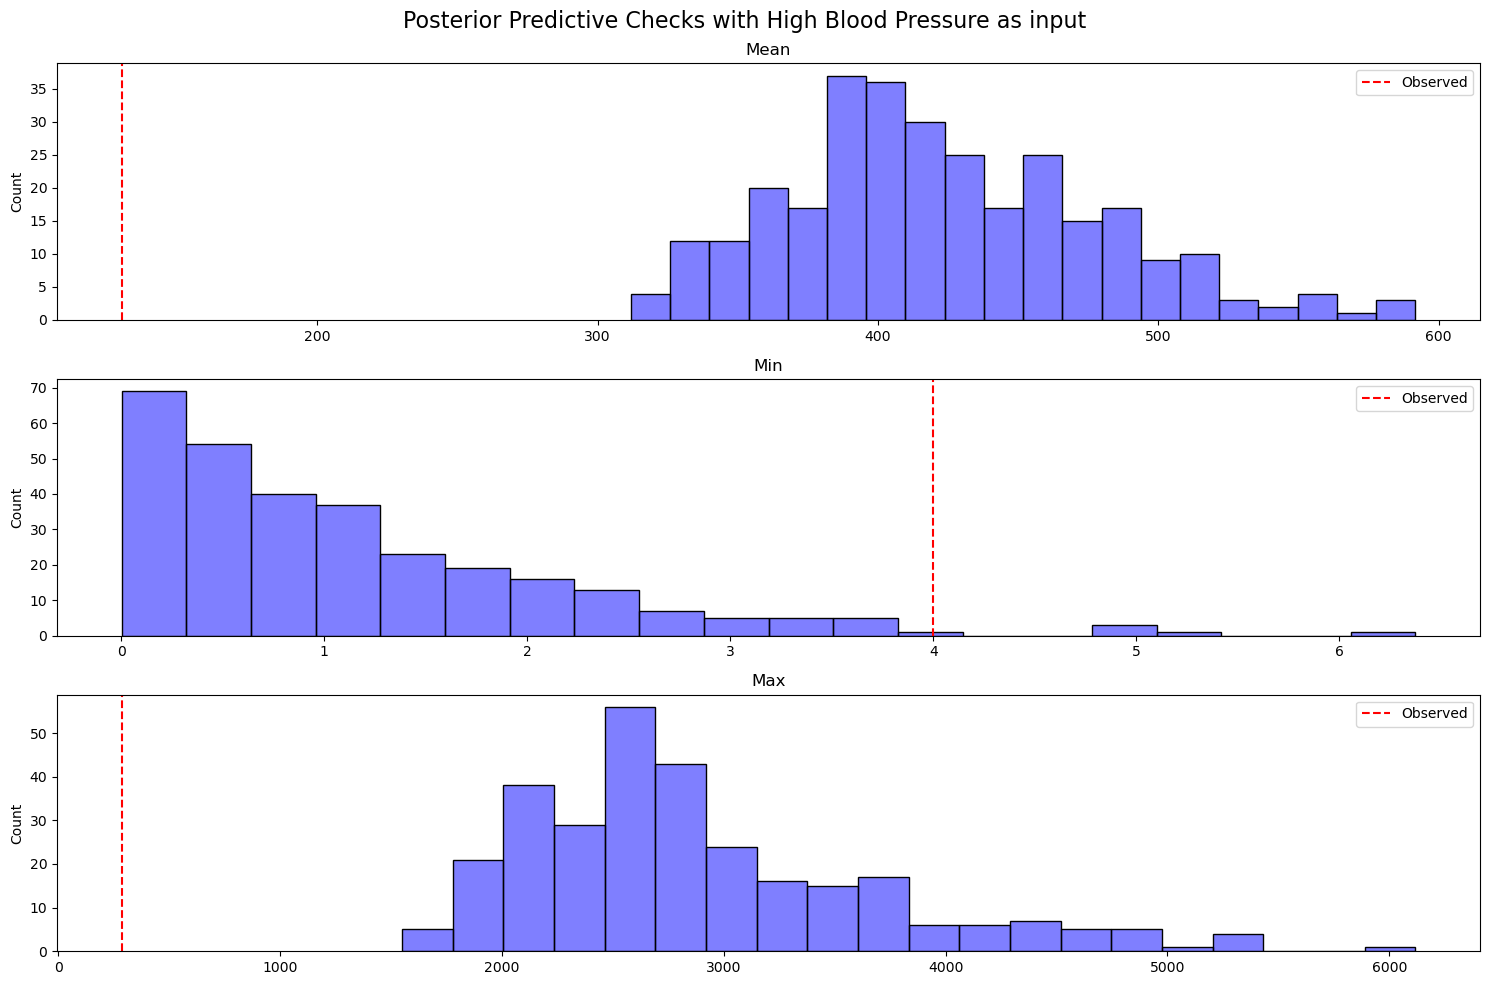

In [23]:
new_samples = np.array(new_samples)

# Generate replicated data
replicated_data = []
counter = 0
for theta in new_samples:
    if(counter >= len(new_t_keep)):
        break
    beta = theta[:-1]
    lamb = theta[-1]
    
    t_rep = np.random.exponential(scale=1 / (lamb * np.exp( np.dot(new_x_keep, beta)) ), size=len(new_x_keep))
    replicated_data.append(t_rep)
    counter += 1

# Compute test quantities
observed_mean = np.mean(new_t_keep)
replicated_means = np.array([np.mean(rep_data) for rep_data in replicated_data])

observed_min = np.min(new_t_keep)
replicated_mins = np.array([np.min(rep_data) for rep_data in replicated_data])

observed_max = np.max(new_t_keep)
replicated_maxs = np.array([np.max(rep_data) for rep_data in replicated_data])

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
labels = ['Mean', 'Min', 'Max']

for i, (observed, replicated, label) in enumerate(zip([observed_mean, observed_min, observed_max],
                                                        [replicated_means, replicated_mins, replicated_maxs],
                                                        labels)):
        sns.histplot(replicated, ax=axes[i], color='blue', alpha=0.5, bins=20)
        axes[i].axvline(observed, color='red', linestyle='--', label='Observed')
        axes[i].set_title(label)
        axes[i].legend()
        
plt.suptitle("Posterior Predictive Checks with Smoking as input", fontsize=16)
plt.tight_layout()
plt.show()

new_MSE = mean_squared_error(new_t_keep, [np.mean(rep_data) for rep_data in replicated_data])
new_MSA = mean_absolute_error(new_t_keep, [np.mean(rep_data) for rep_data in replicated_data])
new_Rsquare = r2_score(new_t_keep, [np.mean(rep_data) for rep_data in replicated_data])

samples = np.array(samples)

# Generate replicated data
replicated_data = []
counter = 0
for theta in samples:
    if(counter >= len(t_keep)):
        break
    beta = theta[:-1]
    lamb = theta[-1]
    
    t_rep = np.random.exponential(scale=1 / (lamb * np.exp( np.dot(x_keep, beta)) ), size=len(x_keep))
    replicated_data.append(t_rep)
    counter += 1
    
# Compute test quantities
observed_mean = np.mean(t_keep)
replicated_means = np.array([np.mean(rep_data) for rep_data in replicated_data])

observed_min = np.min(t_keep)
replicated_mins = np.array([np.min(rep_data) for rep_data in replicated_data])

observed_max = np.max(t_keep)
replicated_maxs = np.array([np.max(rep_data) for rep_data in replicated_data])

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
for i, (observed, replicated, label) in enumerate(zip([observed_mean, observed_min, observed_max],
                                                        [replicated_means, replicated_mins, replicated_maxs],
                                                        labels)):
        sns.histplot(replicated, ax=axes[i], color='blue', alpha=0.5, bins=20)
        axes[i].axvline(observed, color='red', linestyle='--', label='Observed')
        axes[i].set_title(label)
        axes[i].legend()

plt.suptitle("Posterior Predictive Checks with High Blood Pressure as input", fontsize=16)
plt.tight_layout()
plt.show()

MSE = mean_squared_error(t_keep, [np.mean(rep_data) for rep_data in replicated_data])
MSA = mean_absolute_error(t_keep, [np.mean(rep_data) for rep_data in replicated_data])
Rsquare = r2_score(t_keep, [np.mean(rep_data) for rep_data in replicated_data])

The smoking model significantly overestimates mean and maximum survival times, with replicated values clustering far above the observed test quantities, indicating poor alignment with the data. While the minimum survival time shows better agreement, the model struggles to capture the overall range effectively.

The high blood pressure model has the same problem as smoking for mean and max. It also exhibits some understimation for minimum values but falls close to the observed value.

Both models appear to perform similarly for these quantities.

<div class="alert alert-success">
    
**Q11**. Evaluate the posterior predictive performance of both models and discuss the results.

</div>

In [24]:
print(f"Rsquare for High Blood Pressure: {Rsquare}")
print(f"Rsquare for Smoking: {new_Rsquare}")
print()

print(f"Mean Squared Error for High Blood Pressure: {MSE}")
print(f"Mean Squared Error for Smoking: {new_MSE}")
print()

print(f"Mean Absolute Error for High Blood Pressure: {MSA}")
print(f"Mean Absolute Error for Smoking: {new_MSA}")

Rsquare for High Blood Pressure: -14.677889502259456
Rsquare for Smoking: -13.649753033402455

Mean Squared Error for High Blood Pressure: 94127.1988752043
Mean Squared Error for Smoking: 87954.45439572533

Mean Absolute Error for High Blood Pressure: 292.96863799304504
Mean Absolute Error for Smoking: 281.7520323695093


R-squared is a measure of how well the model explains the variance in the data. Both models exhibit negative R-squared values (-14.68 for high blood pressure and -13.65 for smoking), indicating that neither model effectively explains the data, and both perform worse than a simple mean-based model. However, the smoking model has a slightly less negative R-squared value, suggesting it is marginally better at capturing variance, though still far from satisfactory.

Mean Squared Error (MSE) quantifies the average squared difference between predicted and actual values. Smaller values indicate better performance. The MSE for the smoking model (87954.45) is lower than that for the high blood pressure model (94127.20), indicating that the smoking model achieves slightly better overall predictive accuracy by penalizing large prediction errors less severely.

Mean Absolute Error (MAE) calculates the average magnitude of errors. The smoking model again slightly outperforms the high blood pressure model, with a lower MAE of 281.75 compared to 292.97. This suggests that the smoking model makes smaller average prediction errors.

In conclusion, based solely on these metrics, the smoking model appears to perform better. However, the high blood pressure model aligns more closely with the empirical distribution, presenting a seeming contradiction. This discrepancy may suggest that the true survival function is closer to the smoking model than what the empirical distribution indicates.

# Revise

<div class="alert alert-success">
    
**Q12**. Explain and motivate what could be tried to further improve the probabilistic model considered in this study. (No implementation is required.)

</div>

Enhancing the model's predictive accuracy could be achieved by incorporating additional relevant features, which would improve its explanatory power. The current prior distributions, while functional, might be overly simplistic and fail to adequately capture the true parameter distributions. Introducing more informative priors, grounded in domain knowledge or historical data, could result in more accurate posterior estimates. Conducting sensitivity analyses on these priors would provide insights into their influence on model performance. Furthermore, exploring alternative algorithms to MCMC and/or using initial estimates other than MAP could also contribute to achieving better results.